In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

exec('from __future__ import division')

import numpy as np
import os, glob, json
import pickle as pkl
import matplotlib.pyplot as plt
#from matplotlib import colors as mcolors
from matplotlib.patches import Rectangle
spec_colors = {"data": "xkcd:blue",
               "GW_rec": "xkcd:red",
               "GW_inj": "xkcd:purple",
               "glitch_rec": "xkcd:green",
               "glitch_inj": "xkcd:olive"}

import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const
import re

import enterprise_extensions

import corner

import pickle
import emcee

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP

from IPython.core.debugger import set_trace
#from QuickBurst import QuickBurst_MCMC as QB_mcmc

from pylab import cm

In [ ]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [2 * fig_width,2 * fig_height]       #1* scaling factor for 2 collem paper
    return fig_size
plt.rcParams.update(plt.rcParamsDefault)

params = {'backend': 'pdf',
        'axes.labelsize': 18,
        'lines.markersize': 4,
        'font.size': 12,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 13,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        #'font.serif':'Times',
        #'text.latex.preamble': [r'\usepackage{amsmath}'],
        #'text.usetex':True,
        'figure.figsize': figsize(0.5)}
#plt.style.use('dark_background')
plt.style.use('default')
plt.rcParams.update(params)

# Setup

In [ ]:
#Load in pulsar pickle files
with open( "/home/user/path_to/.../data.pkl", 'rb') as f:
    psrs = pickle.load(f)

## Visualizing residuals

In [ ]:
for i, psr in enumerate(psrs):
#     resids = psr.residuals()
    plt.figure(i)      
    plt.errorbar(psr.toas/86400,
            psr.residuals,
            yerr=psr.toaerrs,
            markersize=8, ls='', marker='x', alpha=0.5)
    plt.xlabel('Time [MJD]')
    plt.ylabel(r'Residuals [$\mu$s]')
    plt.title('Pulsar {}'.format(i))
    plt.show()

In [2]:
import h5py
'''
When loading file, can load the following chain properties: 

1) f['samples_cold'] -> Parameter samples for all chains
2) f['log_likelihood'] -> Likelihoods for all chains
3) f['acc_fraction'] -> acceptance fractions for all chains
4) f['param_names'] -> Parameter names for all varied parameters in PTA model. Corresponds to output of pta.param_names().
5) f['swap_record'] -> Record of chain swaps between all chains.
6) f['betas'] -> Record of Temperature values in all chains (as 1/Ts). 
7) f['PT_acc'] -> Parallel tempering acceptance rates for all chains.

'''

filename = '../20_simple_psrs_data/20_simple_psrs_run.h5df'
with h5py.File(filename, 'r+') as f:
    samples_array = f['samples_cold'][()]
    log_likelihood = f['log_likelihood'][()]
    acc_frac = f['acc_fraction'][()]
    param_names = f['par_names'][()]

print(acc_frac)
#print(ent_lnlikelihood)
samples = samples_array

#acceptance rates in order: glitch RJ, glitch tau, wavelet RJ, wavelet tau, N/A, PT swap, fast, regular, noise 

[[       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [       nan        nan        nan        nan        nan]
 [0.44580925 0.47257346 0.36313825 0.41651614        nan]
 [       nan        nan        nan        nan        nan]
 [0.         0.         0.         0.         0.        ]
 [0.80962644 0.8179478  0.8021432  0.79543822 0.79268439]]


In [19]:
np.shape(samples_array)

(5, 100000, 42)

In [23]:
print(combined.shape)

(500000, 42)


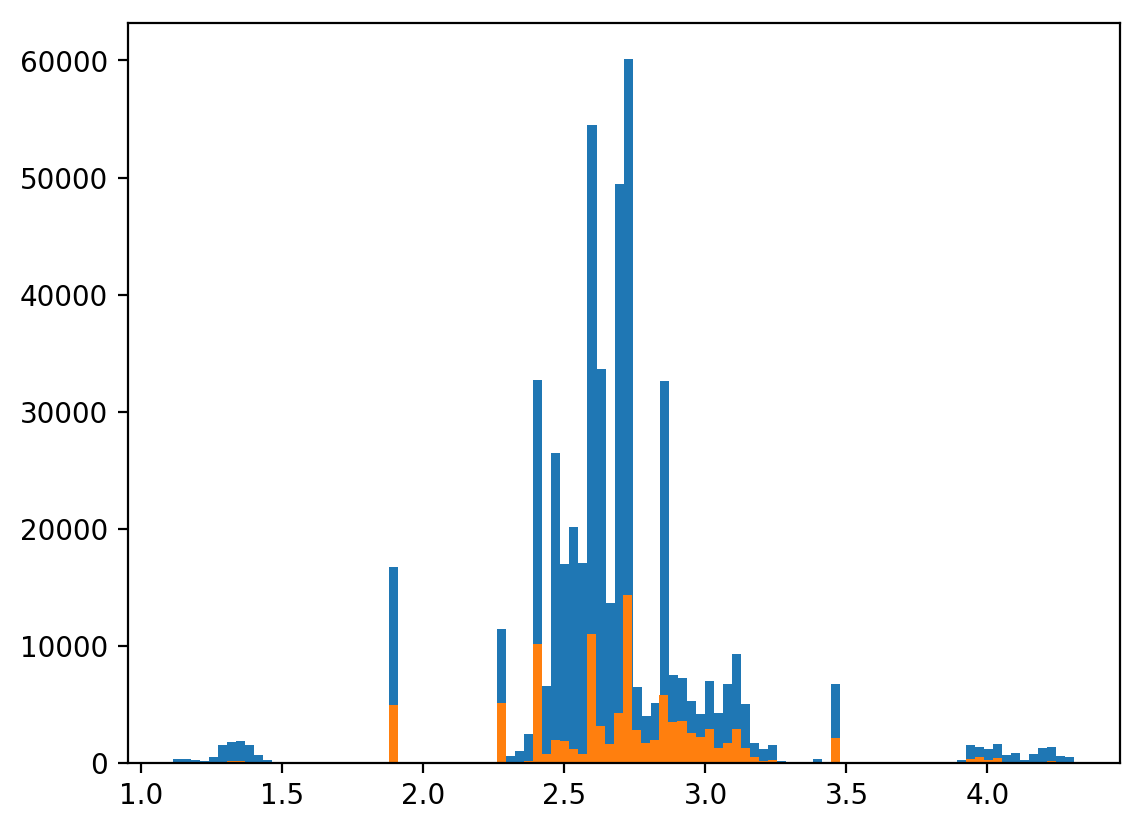

In [35]:
combined = samples.reshape(500000,42)
efacs = combined[:,8]
efacs2 =samples[3,:,8]
n, b, t = plt.hist(efacs,bins=100)
n, b, t = plt.hist(efacs2,bins=100)

In [10]:
print(efacs)

[1.86893795 1.86893795 1.86893795 ... 2.00723135 2.99606074 2.64404788]


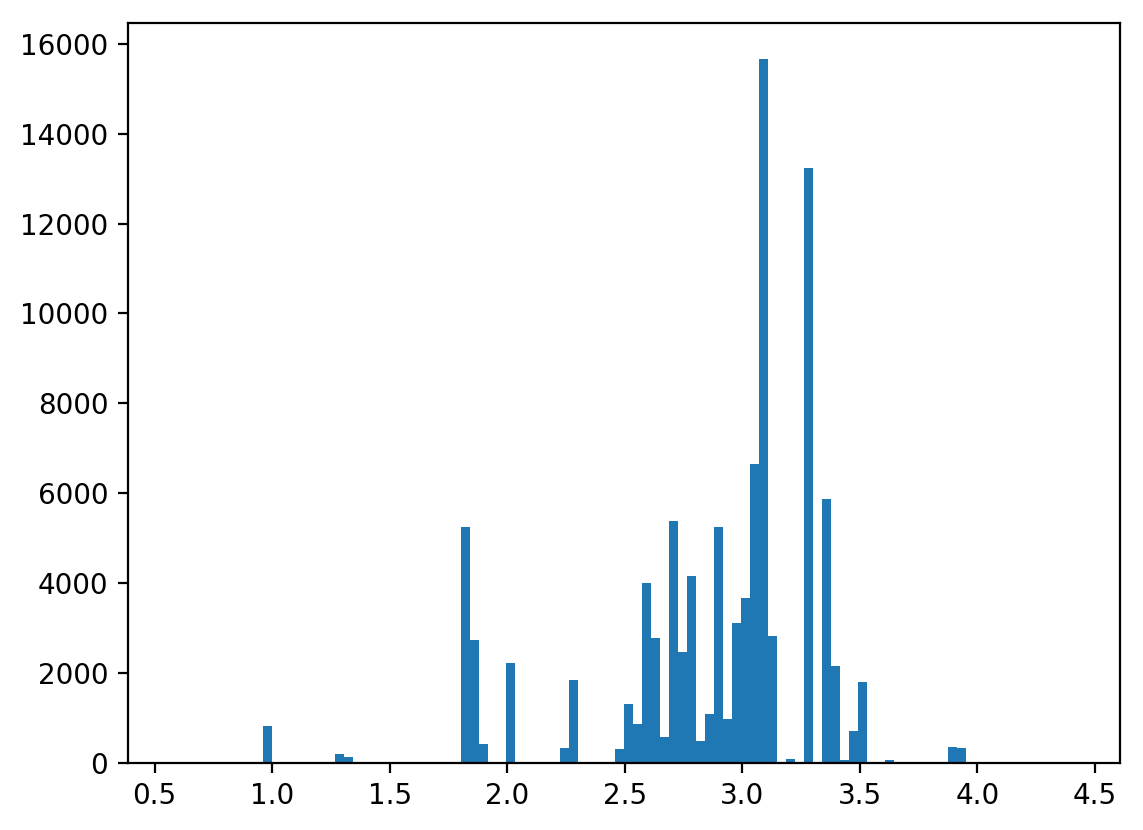

In [13]:
n, b, t = plt.hist(efacs,bins=100)

In [7]:
print(param_names)

[b'JPSR00_efac' b'JPSR00_log10_t2equad' b'JPSR01_efac'
 b'JPSR01_log10_t2equad' b'JPSR02_efac' b'JPSR02_log10_t2equad'
 b'JPSR03_efac' b'JPSR03_log10_t2equad' b'JPSR04_efac'
 b'JPSR04_log10_t2equad' b'JPSR05_efac' b'JPSR05_log10_t2equad'
 b'JPSR06_efac' b'JPSR06_log10_t2equad' b'JPSR07_efac'
 b'JPSR07_log10_t2equad' b'JPSR08_efac' b'JPSR08_log10_t2equad'
 b'JPSR09_efac' b'JPSR09_log10_t2equad' b'JPSR10_efac'
 b'JPSR10_log10_t2equad' b'JPSR11_efac' b'JPSR11_log10_t2equad'
 b'JPSR12_efac' b'JPSR12_log10_t2equad' b'JPSR13_efac'
 b'JPSR13_log10_t2equad' b'JPSR14_efac' b'JPSR14_log10_t2equad'
 b'JPSR15_efac' b'JPSR15_log10_t2equad' b'JPSR16_efac'
 b'JPSR16_log10_t2equad' b'JPSR17_efac' b'JPSR17_log10_t2equad'
 b'JPSR18_efac' b'JPSR18_log10_t2equad' b'JPSR19_efac'
 b'JPSR19_log10_t2equad']


## Thinning chains

# Diagnostic plots

In [ ]:
n_chain = np.shape(samples)[0]
for n in range(n_chain):
    burnin = int(len(log_likelihood[n])*0.35)#50_000
    print('acc_frac: ', acc_frac[6][n])
    print('max: ', max(log_likelihood[n, burnin:]))
    print('min: ', min(log_likelihood[n, burnin:])) #burnin
    plt.plot(log_likelihood[n,burnin:], label = 'QB')

    plt.legend()
    plt.show()

In [ ]:
param_name_list = list(par_name.decode('utf-8') for par_name in param_names)

In [ ]:
param_name_list

# NUMBER OF WAVELETS HISTOGRAM

In [ ]:
#################################################################
#
# NUMBER OF WAVELETS HISTOGRAM
#
#################################################################

#do not replace 0s with nans in this case
n_chain = 0
burnin = int(len(log_likelihood[n_chain])*0.25)
samples_burned = samples[n_chain,burnin:,:]

max_corr_l=0.001

print(int(np.nanmax(samples_burned[:,0])))
#bins = np.arange(-1,int(np.nanmax(samples_burned[:,0]))+1) + 0.5
########################################
min_n = 0
max_n = 5
########################################
bins = np.arange(min_n-1,max_n+1) + 0.5
print(bins)
N = np.shape(samples_burned[:,0])[0]
print(N)
hist, bin_edges = np.histogram(samples_burned[:,0], bins)
print(hist/N*100)
poisson_error = np.sqrt(hist/max_corr_l)/(N/max_corr_l)*100
print(poisson_error)
plt.bar(bin_edges[:-1]+0.5, hist/N*100, yerr=poisson_error, fill=False, edgecolor='b', linewidth=2, ecolor='b',
        capsize=None, error_kw={'elinewidth':2}, label='posterior')

bin_edges_signal = bin_edges
hist_signal = hist

########################################
n_source_prior = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
########################################
prior_hist = n_source_prior/np.sum(n_source_prior)*100
plt.bar(bin_edges[:-1]+0.5, prior_hist, fill=False, edgecolor='r', linewidth=2, ls='--',
        label='prior')

plt.legend(loc=3)
#plt.yscale('log', nonposy='clip')
plt.xlabel("Number of wavelets")
plt.ylabel("% of samples")

plt.xticks(np.arange(min_n, max_n+1, step=1.0))

bayes_factor = hist[1]/hist[0]*n_source_prior[0]/n_source_prior[1] #compensating for our non-uniform prior

print(poisson_error/(hist/N*100))

bf_error = np.sum(poisson_error/(hist/N*100))*bayes_factor

print("best prior would have been: n_source_prior= ",1/hist*prior_hist*1000)

#plt.text(0.65,60,r'$B_{{\rm GWB}}^{{\rm RJ}}={0:.4f}\pm {1:.4f}$'.format(bayes_factor, bf_error), fontdict={'size':10})
#plt.title(r'$B_{{\rm CW}}^{{\rm RJ}}={0:.4f}\pm {1:.4f}$'.format(bayes_factor, bf_error))

#plt.axhline(y=100.0/np.max(samples_burned[:,0]), color='r')
#plt.ylim((20,30))
#plt.xlim((0.5,3.0))
plt.grid(which='both')
plt.tight_layout()
# plt.savefig("/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Plots/Paper_Plots/60Mpc_RN/10yrs_psrs/Signal_wavelet_recovery.png", dpi=600)
plt.show()

# NUMBER OF GLITCHES HISTOGRAM

In [ ]:
#################################################################
#
# NUMBER OF GLITCHES HISTOGRAM
#
#################################################################


max_corr_l=0.001

print(int(np.nanmax(samples_burned[:,1])))
#bins = np.arange(-1,int(np.nanmax(samples_burned[:,0]))+1) + 0.5
########################################
min_n = 0
max_n = 5
########################################
bins = np.arange(min_n-1,max_n+1) + 0.5
print(bins)
N = np.shape(samples_burned[:,1])[0]
print(N)
hist, bin_edges = np.histogram(samples_burned[:,1], bins)
print(hist/N*100)
poisson_error = np.sqrt(hist/max_corr_l)/(N/max_corr_l)*100
print(poisson_error)
plt.bar(bin_edges[:-1]+0.5, hist/N*100, yerr=poisson_error, fill=False, edgecolor='b', linewidth=2, ecolor='b',
        capsize=None, error_kw={'elinewidth':2}, label='posterior')

bin_edges_glitch = bin_edges
hist_glitch = hist

########################################
n_source_prior = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
#n_source_prior = np.ones(25+1)
########################################
prior_hist = n_source_prior/np.sum(n_source_prior)*100
plt.bar(bin_edges[:-1]+0.5, prior_hist, fill=False, edgecolor='r', linewidth=2, ls='--',
        label='prior')

plt.legend(loc=3)
#plt.yscale('log', nonposy='clip')
plt.xlabel("Number of glitches")
plt.ylabel("% of Samples")

plt.xticks(np.arange(min_n, max_n+1, step=1.0))

bayes_factor = hist[1]/hist[0]*n_source_prior[0]/n_source_prior[1] #compensating for our non-uniform prior

print(poisson_error/(hist/N*100))

bf_error = np.sum(poisson_error/(hist/N*100))*bayes_factor

print("best prior would have been: n_source_prior= ",1/hist*prior_hist*1000)

#plt.text(0.65,60,r'$B_{{\rm GWB}}^{{\rm RJ}}={0:.4f}\pm {1:.4f}$'.format(bayes_factor, bf_error), fontdict={'size':10})
#plt.title(r'$B_{{\rm CW}}^{{\rm RJ}}={0:.4f}\pm {1:.4f}$'.format(bayes_factor, bf_error))

#plt.axhline(y=100.0/np.max(samples_burned[:,0]), color='r')
#plt.ylim((20,30))
#plt.xlim((0.5,3.0))
plt.grid(which='both')
plt.tight_layout()
# plt.savefig("/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Plots/Paper_Plots/60Mpc_RN/10yrs_psrs/Noise_wavelet_recovery.png", dpi=600)
plt.show()

# Combined Wavelet + Glitch histograms

In [ ]:
#do not replace 0s with nans in this case
n_chain = 0
burnin = int(len(log_likelihood[n_chain])*0.50)
samples_burned = samples[n_chain,burnin:,:]
max_corr_l=0.001

########################################
#GLITCH HISTOGRAM
########################################

########################################
glitch_min_n = 0
glitch_max_n = 5
########################################
glitch_bins = np.arange(glitch_min_n-1,glitch_max_n+1) + 0.5
print(glitch_bins)
N = np.shape(samples_burned[:,1])[0]
print(N)

glitch_hist, glitch_bin_edges = np.histogram(samples_burned[:,1], glitch_bins)
glitch_poisson_error = np.sqrt(glitch_hist/max_corr_l)/(N/max_corr_l)*100
print(glitch_poisson_error)

print('Probability of wavelet per bin: ', [glitch_hist[i]/N for i in range(len(glitch_hist))])
plt.bar(glitch_bin_edges[:-1]+0.5, glitch_hist/N*100, yerr=glitch_poisson_error, fill=False, alpha = 0.5, edgecolor='red', linewidth=2,
        capsize=None, hatch = "x", error_kw={'elinewidth':2}, label='Noise Transient Posterior')


########################################
wavelet_min_n = 0
wavelet_max_n = 5
########################################
wavelet_bins = np.arange(wavelet_min_n-1,wavelet_max_n+1) + 0.5
print(wavelet_bins)

wavelet_hist, wavelet_bin_edges = np.histogram(samples_burned[:,0], wavelet_bins)
wavelet_poisson_error = np.sqrt(wavelet_hist/max_corr_l)/(N/max_corr_l)*100
print(wavelet_poisson_error)

print('Probability of wavelet per bin: ', [wavelet_hist[i]/N for i in range(len(wavelet_hist))])
plt.bar(wavelet_bin_edges[:-1]+0.5, wavelet_hist/N*100, yerr=wavelet_poisson_error, fill=False, alpha = 0.5, edgecolor='blue', linewidth=2, 
        capsize=None, hatch = ".", error_kw={'elinewidth':2}, label='Signal Wavelet Posterior')

########################################
n_source_prior = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
#n_source_prior = np.ones(25+1)
########################################
prior_hist = n_source_prior/np.sum(n_source_prior)*100
plt.bar(wavelet_bin_edges[:-1]+0.5, prior_hist, fill=False, edgecolor='green', linewidth=2, ls='--',
        label='Bayesian prior')

plt.ylim((0, 105))
plt.xlabel("Number of wavelets")
plt.ylabel("% of Samples")
plt.grid(which='both')
plt.tight_layout()
plt.legend()
# plt.savefig("/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Plots/Paper_Plots/Simple_20PSR_30Mpc_parabolic_flyby/CURNvarried_largeA_13_3_skyshift/Wavelet_glitch_posterior.pdf", dpi=600)
plt.show()

# BAYESOGRAMS

In [ ]:
# #Loading in pickle and noise files for 2 wavelet
noise_file_sim = "/home/user/path_to/.../noise_dict.json"
with open(noise_file_sim, 'r') as h:
    noise_params = json.load(h)
noise_params

In [ ]:
#Setting dataset max time and reference time
maximum = 0
minimum = np.inf
for psr in psrs:
    if psr.toas.max() > maximum:
        maximum = psr.toas.max()
    if psr.toas.min() < minimum:
        minimum = psr.toas.min()


#Sets reference time
tref = minimum

t0_max = (maximum - minimum)/365/24/3600
print(t0_max)

## Setting up components for reconstructions

### Check PTA matches PTA generated from QuickBurst.py

In [ ]:
from la_forge.gp import Signal_Reconstruction as gp
from la_forge.utils import epoch_ave_resid

In [ ]:
#Set to True if no burst injection in dataset
#Will set burst injection curve to 0.
no_burst = False

############################################################
#
#BAYESOGRAMS 2?
#
############################################################
def WNBSimulator(t, A, t0, f0, delt, delf, wnb_seed):
    
    #generate white noise in time domain first
    np.random.seed(wnb_seed)
    h_plus = np.random.normal(scale=A, size=t.size)
    h_cross = np.random.normal(scale=A, size=t.size)

    #widnow it in the time domain
    h_plus *= np.exp(-(t-t0)**2/delt**2)
    h_cross *= np.exp(-(t-t0)**2/delt**2)

    #fft them
    h_plus = np.fft.rfft(h_plus)
    h_cross = np.fft.rfft(h_cross)
    f = np.fft.rfftfreq(t.size, d=t[1]-t[0])
    #print(f)

    #window it in the frequency domain
    h_plus *= np.exp(-(f-f0)**2/delf**2)
    h_cross *= np.exp(-(f-f0)**2/delf**2)

    #ifft them back to time domain
    h_plus = np.fft.irfft(h_plus)
    h_cross = np.fft.irfft(h_cross)
    
    return h_plus, h_cross

def parabolic_signal(t, m1, m2, b, t_pericenter, dist, tref):
    #total mass
    M = m1+m2
    #reduced mass
    mu = m1*m2/M
    #print(t + tref - t_pericenter*24*3600)
    #time vector shifted so that ttt=0 at pericenter passage
    ttt = t + tref - t_pericenter*24*3600 #seconds
    speed_of_light = 299792458.0 #m/s
    T_sun = 1.327124400e20 / speed_of_light**3 #G*M_sun/c^3 = R_sun/c-->Sun time
    ttt *= 1/T_sun

    #pc to meter
    pc_meter = 3.08567758149137e16

    #parameters from Finn&Lommen(2010) eq. (4-2d) and (4-2e)
    w0 = np.sqrt(8+9*M/b*(ttt/b)**2)
    w1 = (3*ttt/b*np.sqrt(M/b)+w0)**(1/3)

    #calculate quadrupole moment time derivatives -- Finn&Lommen(2010) eq. (4-3a-c)
    Q_xx_dot = mu*b/(np.sqrt(2)*w0*w1**4) * np.sqrt(M/b) * (w1**4-4) * (w1**4-6*w1**2+4)  #solar mass**2
    Q_yy_dot = 4*mu*b/(w0*w1**2) * np.sqrt(M/b) * (w1**4-4)                               #solar mass**2
    Q_xy_dot = mu*b/(np.sqrt(2)*w0*w1**3) * np.sqrt(M/b) * (-3*w1**6+8*w1**4+16*w1**2-24) #solar mass**2
    
    H_plus = 2/(dist*1e6*pc_meter/speed_of_light/T_sun)*(Q_xx_dot-Q_yy_dot) #solar mass
    H_cross = 2/(dist*1e6*pc_meter/speed_of_light/T_sun)*2*Q_xy_dot #solar mass

    H_plus *= T_sun #seconds
    H_cross *= T_sun #seconds
    
    return H_plus, H_cross

rnd_i = 20#68#42#56



####################
#PTA generation below. Settings need to change for each run.
####################

n_chain = 0

#If chain is thinned, use regular samples
burnin = int(len(samples[n_chain,:,0])*0.35)#50_000
samples_burned = samples[n_chain,burnin:,:]

#How much to thin the burned chain. Thinned chain will set how many samples are used for waveform reconstructions.
# thin=100
thin=1000
#thin = 3000

print('samples_burned shape: ', np.shape(samples_burned))
print('Thinned samples_burned shape: ', samples_burned[::thin,:].shape)

max_n_wavelets = 5
max_n_glitches = 3
PTA, QB_FP, QB_FPI, glitch_indx, wavelet_indx, per_puls_indx, rn_indx, num_per_puls_wn_param_list = QB_mcmc.get_pta(psrs, 
                                                                                                            vary_white_noise = False,
                                                                                                            max_n_wavelet=max_n_wavelets, 
                                                                                                            max_n_glitch=max_n_glitches,   
                                                                                                            include_equad = True, 
                                                                                                            include_ecorr = False, 
                                                                                                            wn_backend_selection=False, 
                                                                                                            noisedict=noise_params, 
                                                                                                            include_efac=True,
                                                                                                            include_rn=False, 
                                                                                                            vary_rn=False, 
                                                                                                            include_per_psr_rn=False, 
                                                                                                            vary_per_psr_rn=False, t0_max = t0_max, tref = tref) 

print(wavelet_indx)
print(glitch_indx)

###################
#GW delays
###################

#get max number of observations
print([psrs[i].toas.shape[0] for i in range(len(psrs))])
max_obs = np.max([psrs[i].toas.shape[0] for i in range(len(psrs))])
print(max_obs)

#get all the delays from samples
all_delays = np.zeros( (int(samples_burned.shape[0]/thin), len(psrs), max_obs) )
print('Shape of all_delays: ', np.shape(all_delays))
for ii in range(int(samples_burned.shape[0]/thin)):
    
    n_wavelet = int(samples_burned[ii*thin,0])

    xxx = {}
    for jj in range(n_wavelet):
        xxx['wavelet_'+str(jj)+"_cos_gwtheta"] = samples_burned[ii*thin,2+wavelet_indx[jj,0]]
        xxx['wavelet_'+str(jj)+"_gw_psi"] = samples_burned[ii*thin,2+wavelet_indx[jj,1]]
        xxx['wavelet_'+str(jj)+"_gwphi"] = samples_burned[ii*thin,2+wavelet_indx[jj,2]]
        xxx['wavelet_'+str(jj)+"_log10_f0"] = samples_burned[ii*thin,2+wavelet_indx[jj,3]]
        xxx['wavelet_'+str(jj)+"_log10_h"] = samples_burned[ii*thin,2+wavelet_indx[jj,4]]
        xxx['wavelet_'+str(jj)+"_log10_h_cross"] = samples_burned[ii*thin,2+wavelet_indx[jj,5]]
        xxx['wavelet_'+str(jj)+"_phase0"] = samples_burned[ii*thin,2+wavelet_indx[jj,6]]
        xxx['wavelet_'+str(jj)+"_phase0_cross"] = samples_burned[ii*thin,2+wavelet_indx[jj,7]]
        xxx['wavelet_'+str(jj)+"_t0"] = samples_burned[ii*thin,2+wavelet_indx[jj,8]]
        xxx['wavelet_'+str(jj)+"_tau"] = samples_burned[ii*thin,2+wavelet_indx[jj,9]]

    delay_all_psr = PTA.get_delay(xxx)
    for kk in range(len(psrs)):
        all_delays[ii,kk,:psrs[kk].toas.shape[0]] = delay_all_psr[kk]
        
#     if ii==rnd_i:
#         print("Random draw samples:")
#         print(samples_burned[ii*thin,:])
#         delay_rnd_draw = np.copy(delay_all_psr)
#         wavelets_rnd_draw = np.zeros( (int(n_wavelet), len(psrs), max_obs), dtype = "object")
#         print('wavelets_rnd_draw: ', np.shape(wavelets_rnd_draw))
#         #print(n_wavelet)
#         #print(xxx)
#         for jj in range(n_wavelet):
#             print({key:xxx[key] for key in xxx.keys() if key[0]==str(jj)})
#             wavelets_rnd_draw[jj,:,:] = PTA.get_delay({key:xxx[key] for key in xxx.keys() if key[0]==str(jj)})
            #print(wavelets_rnd_draw[jj,0,:])

#print(delay_rnd_draw.shape)
#print(wavelets_rnd_draw.shape)
#print(wavelets_rnd_draw)

print(all_delays.shape)
    
#calculate median and 90%CI delay
median_delays = np.zeros( (len(psrs), max_obs) )
lower90_delays = np.zeros( (len(psrs), max_obs) )
upper90_delays = np.zeros( (len(psrs), max_obs) )
for kk in range(len(psrs)):
    for ll in range(psrs[kk].toas.shape[0]):
        median_delays[kk,ll] = np.median(all_delays[:,kk,ll])
        upper90_delays[kk,ll] = np.percentile(all_delays[:,kk,ll], 95)
        lower90_delays[kk,ll] = np.percentile(all_delays[:,kk,ll], 5)

# Use models.wavelet_delay with median_delay wavelet parameter values to plot over residuals (and superimpose all wavelets)

###################
#Glitch delays
###################

#get all the delays from samples
#all_glitch_delays[sample, psr, MJD] -> [sample, psr, 0] corresponds to the starting observing MJD for psr. i.e. MJD ~2008 for B1855.
all_glitch_delays = np.zeros( (int(samples_burned.shape[0]/thin), len(psrs), max_obs) )
for ii in range(int(samples_burned.shape[0]/thin)):
    #print(ii)
    n_glitch = int(samples_burned[ii*thin,1])
    xxx = {}
    for jj in range(n_glitch):
        xxx["Glitch_"+str(jj)+"_log10_f0"] = samples_burned[ii*thin,2+glitch_indx[jj,0]]
        xxx["Glitch_"+str(jj)+"_log10_h"] = samples_burned[ii*thin,2+glitch_indx[jj,1]]
        xxx["Glitch_"+str(jj)+"_phase0"] = samples_burned[ii*thin,2+glitch_indx[jj,2]]
        xxx["Glitch_"+str(jj)+"_psr_idx"] = samples_burned[ii*thin,2+glitch_indx[jj,3]]
        xxx["Glitch_"+str(jj)+"_t0"] = samples_burned[ii*thin,2+glitch_indx[jj,4]]
        xxx["Glitch_"+str(jj)+"_tau"] = samples_burned[ii*thin,2+glitch_indx[jj,5]]

    
    #print(samples_burned[burnin+ii,:])
    #print(xxx)
    delay_all_psr_glitch = PTA.get_delay(xxx)
    for kk in range(len(psrs)):
        all_glitch_delays[ii,kk,:psrs[kk].toas.shape[0]] = delay_all_psr_glitch[kk]
        
    #if ii==rnd_i:
    #    delay_rnd_draw = np.copy(delay_all_psr)
    #    wavelets_rnd_draw = np.zeros( (int(n_wavelet), len(psrs), psrs[0].toas.shape[0]) )
    #    print(n_wavelet)
    #    print(xxx)
    #    for jj in range(n_wavelet):
    #        print({key:xxx[key] for key in xxx.keys() if key[0]==str(jj)})
    #        wavelets_rnd_draw[jj,:,:] = pta.get_delay({key:xxx[key] for key in xxx.keys() if key[0]==str(jj)})
    #        print(wavelets_rnd_draw[jj,0,:])

#print(delay_rnd_draw.shape)
#print(wavelets_rnd_draw.shape)
#print(wavelets_rnd_draw)
    
#calculate median and 90%CI delay
median_glitch_delays = np.zeros( (len(psrs), max_obs) )
lower90_glitch_delays = np.zeros( (len(psrs), max_obs) )
upper90_glitch_delays = np.zeros( (len(psrs), max_obs) )
for kk in range(len(psrs)):
    for ll in range(psrs[kk].toas.shape[0]):
        median_glitch_delays[kk,ll] = np.median(all_glitch_delays[:,kk,ll])
        upper90_glitch_delays[kk,ll] = np.percentile(all_glitch_delays[:,kk,ll], 95)
        lower90_glitch_delays[kk,ll] = np.percentile(all_glitch_delays[:,kk,ll], 5)
        #if kk==0:
        #    print(all_glitch_delays[:,kk,ll])

##################
#injected delays (if explicitly injecting wavelets into data)
###################
x_glitch_true = {
    'Glitch_0_log10_f0':np.log10(6e-8),
#    'Glitch_0_log10_h':np.log10(5e-6), #medium amp
#    'Glitch_0_log10_h':np.log10(2e-6), #low amp
    'Glitch_0_log10_h':np.log10(1e-6), #very low amp
    'Glitch_0_phase0':1.0,
    'Glitch_0_psr_idx':0.0,
    'Glitch_0_t0':2500.0/365.25, #year
    'Glitch_0_tau':300.0/365.25, #year
}

#2wavelet_very_low_amp_not_ell_pol
x_gw = {
    'wavelet_0_cos_gwtheta':np.cos(np.pi/2),
    'wavelet_0_gw_psi':0.0,
    'wavelet_0_gwphi':0.0,
    'wavelet_0_log10_f0':np.log10(3e-8),
    'wavelet_0_log10_h':np.log10(1.25e-6), #low amp
    'wavelet_0_log10_h_cross':np.log10(1.25e-6), #low amp
    'wavelet_0_phase0':0.0,
    'wavelet_0_phase0_cross':0.0,
    'wavelet_0_t0':1000.0/365.25, #year
    'wavelet_0_tau':200.0/365.25, #year
    'wavelet_1_cos_gwtheta':np.cos(np.pi/2),
    'wavelet_1_gw_psi':0.0,
    'wavelet_1_gwphi':0.0,
    'wavelet_1_log10_f0':np.log10(4e-8),
    'wavelet_1_log10_h':np.log10(1e-6), #low amp
    'wavelet_1_log10_h_cross':np.log10(1e-6), #low amp
    'wavelet_1_phase0':2.0,
    'wavelet_1_phase0_cross':2.0,
    'wavelet_1_t0':1300.0/365.25, #year
    'wavelet_1_tau':500.0/365.25, #year
}

delays_glitch = PTA.get_delay(x_glitch_true)
delays_gw = PTA.get_delay(x_gw)


## Parabolic injection

In [ ]:
#WNB injected
t0 = 6.0*365.25*24*3600 #seconds
f0 = 6e-8 #Hz
delt = 1.0*365.25*24*3600 #seconds
delf = 4e-8 #Hz
amplitude = 2e-6
wnb_seed = 12345678

#inj_plus, inj_cross = WNBSimulator(t, amplitude, t0, f0, delt, delf, wnb_seed)

def inj_plus_wnb(t):
    inj_plus, inj_cross = WNBSimulator(t, amplitude, t0, f0, delt, delf, wnb_seed)
    return inj_plus

def inj_cross_wnb(t):
    inj_plus, inj_cross = WNBSimulator(t, amplitude, t0, f0, delt, delf, wnb_seed)
    return inj_cross

#parameters
#masses
m1 = 1e9 #solar mass
m2 = 1e9 #solar mass
#impact parameter
#b = 180*(m1+m2)
b = 60*(m1+m2) #short
#pericenter passage time
t_pericenter = 55000 #MJD
#distance
#dist = 15 #Mpc #high amp
#dist = 3 #Mpc #higher amp
dist = 30 #Mpc #low amp
#sky location
gw_theta = np.pi/2
gw_phi = 4.0 #3.7
#polarization (not needed for reconstructions, only skymap)
psi = 0.0 #0.2

def inj_plus_parabolic(t):
    inj_plus, inj_cross = parabolic_signal(t, m1, m2, b, t_pericenter, dist, tref)
    return inj_plus

def inj_cross_parabolic(t):
    inj_plus, inj_cross = parabolic_signal(t, m1, m2, b, t_pericenter, dist, tref)
    return inj_cross

wnb_gw_delays = []
parabolic_gw_delays = []
for ii, psr in enumerate(psrs):
    # define variable for later use
    cosgwtheta, cosgwphi = np.cos(gw_theta), np.cos(gw_phi)
    singwtheta, singwphi = np.sin(gw_theta), np.sin(gw_phi)

    # unit vectors to GW source
    m = np.array([singwphi, -cosgwphi, 0.0])
    n = np.array([-cosgwtheta*cosgwphi, -cosgwtheta*singwphi, singwtheta])
    omhat = np.array([-singwtheta*cosgwphi, -singwtheta*singwphi, -cosgwtheta])

    # pulsar location
    ptheta = psr.theta
    pphi = psr.phi

    # use definition from Sesana et al 2010 and Ellis et al 2012
    phat = np.array([np.sin(ptheta)*np.cos(pphi), np.sin(ptheta)*np.sin(pphi),\
            np.cos(ptheta)])

    #print(ptheta, pphi, gwtheta, gwphi)

    fplus = 0.5 * (np.dot(m, phat)**2 - np.dot(n, phat)**2) / (1+np.dot(omhat, phat))
    fcross = (np.dot(m, phat)*np.dot(n, phat)) / (1 + np.dot(omhat, phat))

    # get toas from pulsar object
    toas = psr.toas - tref
    #print(toas)
    ################## WNB

    # define residuals: rplus and rcross
    rplus_wnb = inj_plus_wnb(toas)
    rcross_wnb = inj_cross_wnb(toas)

    # residuals
    res_wnb = -fplus*rplus_wnb - fcross*rcross_wnb

    wnb_gw_delays.append( np.array(res_wnb))
    
    ################### Parabolic
    
    # define residuals: rplus and rcross
    rplus_parabolic = inj_plus_parabolic(toas)
    rcross_parabolic = inj_cross_parabolic(toas)
    
    #apply rotation by psi angle (see e.g. eq. (7.24-25) in Maggiore Vol1, 2008)
    rplus = rplus_parabolic*np.cos(2*psi) - rcross_parabolic*np.sin(2*psi)
    rcross = rplus_parabolic*np.sin(2*psi) + rcross_parabolic*np.cos(2*psi)

    # residuals
    res_parabolic = -fplus*rplus - fcross*rcross
    
    #remove quadratic fit
    pp = np.polyfit(np.array(toas, dtype=np.double), np.array(res_parabolic, dtype=np.double), 2)
    res_parabolic = res_parabolic - pp[0]*toas**2 -pp[1]*toas - pp[2]

    if no_burst:
        res_parabolic = 0*res_parabolic
    parabolic_gw_delays.append( np.array(res_parabolic))

print(upper90_glitch_delays[0,:]*1e6)

print(wnb_gw_delays[0])

## Calculating match statistic between injection and mean signal reconstruction

### If you're looking at real data:
1) delays_list = [median_delays, median_delays], which will give you the SNR of your median signal reconstruction.
### If you're looking at simulated data:
1) If you're looking at a non-exact waveform injection:
   2) delays_list = [median_delays, parabolic_gw_delays], which will give you the SNR of all inner product combinations between the median recovery and injected signal.
3) If you're looking at an exact waveform injection:
   1) Tune the parameter "delays_gw" to the exact waveform that's been injected.
   2) Set delays_list = [median_delays, delays_gw] to compute the inner products.

In [ ]:
###
#IF VARYING ANY NOISE: -> PASS IN PARAMS DICTIONARY
###

delays_list = [median_delays, parabolic_gw_delays]

S_matrix = QB_mcmc.get_similarity_matrix(PTA, psrs, delays_list, noise_param_dict = None)

M_matrix = QB_mcmc.get_match_matrix(PTA, psrs, delays_list, noise_param_dict=noise_params)

Match = M_matrix[1,0]
SNR_inj = np.sqrt(S_matrix[1,1])
SNR_rec = np.sqrt(S_matrix[0,0])

print(S_matrix)
print(M_matrix)
print("Injected SNR: ", SNR_inj)
print("Recovered SNR: ", SNR_rec)
print("Match between injected and recovered waveform: ", Match)

# Main reconstruction plotting loop

# 1) For realistic datasets

In [ ]:
plot_path = '/home/user/path_to/plot_folder'
os.makedirs(plot_path, exist_ok = True)
#print(wnb_gw_delays[0])
for idx in range(len(psrs)):

    plt.close()
    print('plotting: ', psrs[idx].name)

    sr=gp(psrs,PTA,chain=samples[0,burnin:,2:])
    #print(sr.gp_types)

    sec_to_day = 24*3600
    psrname = psrs[idx].name

    # parameter indices to pull from chain. Change `size` flag for more or less.
    idxs = np.random.randint(0, sr.chain.shape[0],size=30)
    
    ########## GP models to subtract out of residuals ############
    
#     linear_timing_gp = np.array([sr.reconstruct_signal(gp_type='timing', idx=idx)[psrname]
#                     for idx in idxs])
#     timing_piece_gp = np.array([sr.reconstruct_signal(gp_type=psrs[idx].fitpars[idx], idx=indx)[psrname]
#                     for idx in idxs])
#     com_rn_gp = np.array([sr.reconstruct_signal(gp_type='rn', idx=idx)[psrname]
#                     for idx in idxs])
#     rn_gp = np.array([sr.reconstruct_signal(gp_type='red_noise', idx=idx)[psrname]
#                     for idx in idxs])
    all_gp = np.array([sr.reconstruct_signal(gp_type='all', idx=idx)[psrname]
                    for idx in idxs])
#     linear_timing_gp_mean = np.mean(linear_timing_gp,axis=0)
#     timing_piece_gp_mean = np.mean(timing_piece_gp,axis=0)
#     com_rn_gp_mean = np.median(com_rn_gp,axis=0)
#     rn_gp_mean = np.median(rn_gp,axis=0)
    all_gp_mean = np.median(all_gp,axis=0)
    
#     #upper 90%
#     linear_timing_gp_upper = np.percentile(linear_timing_gp, 95,axis=0)
#     rn_gp_upper = np.percentile(rn_gp_mean, 95, axis=0)
#     com_rn_gp_upper = np.percentile(com_rn_gp, 95,axis=0)
    all_gp_upper = np.percentile(all_gp, 95,axis=0)
    
    #lower 90%
#     linear_timing_gp_lower = np.percentile(linear_timing_gp, 5,axis=0)
#     rn_gp_lower = np.percentile(rn_gp_mean, 5, axis=0)
#     com_rn_gp_lower = np.percentile(com_rn_gp, 5,axis=0)
    all_gp_lower = np.percentile(all_gp, 5,axis=0)
    
    ############ End of models to subtract out ###############   
    
    ###############################
    #
    #EPOCH averaging w/ la_forge
    #
    ###############################

    sec_to_day = 24*3600

    resids, msks = epoch_ave_resid(psrs[idx])  
    print('resids keys 1:', resids.keys())
    resids_corr, msks_corr = epoch_ave_resid(psrs[idx], correction=all_gp_mean) #+ parabolic_gw_delays[idx]) #subtracting the median RN and Burst
    print('resids_corr keys:', resids_corr.keys())
    
    psrCorr_AveTOAs = resids_corr[list(resids_corr.keys())[0]][:,0]
    psrCorr_AveResids = resids_corr[list(resids_corr.keys())[0]][:,1]
    psrCorr_AveResid_err = resids_corr[list(resids_corr.keys())[0]][:,2]
    
    psr_AveTOAs = resids[list(resids.keys())[0]][:,0]
    psr_AveResids = resids[list(resids.keys())[0]][:,1]
    psr_AveResid_err = resids[list(resids.keys())[0]][:,2]
    ###############################
    #
    #END OF EPOCH averaging
    #
    ###############################
    
    '''BEGIN PLOTTING'''

    """Plot GP models individually. Good for visually checking model covariances, if applicable. """
    #plt.plot(psr.toas/sec_to_day,linear_timing_gp_mean*1e6, label='Timing', ls='', marker='x')
    #plt.plot(psr.toas/sec_to_day,timing_piece_gp_mean*1e6, label=psrs[0].fitpars[idx], ls='', marker='x')
    #plt.plot(psr.toas/sec_to_day,com_rn_gp_mean*1e6, label='Com RN')
    #plt.plot(psr.toas/sec_to_day,rn_gp_mean*1e6, label='Individual RN')
    #plt.plot(psrs[idx].toas/sec_to_day,all_gp_mean*1e6, label='GP All', ls='', marker='x')

    #plt.legend()
    
    fig, ax1 = plt.subplots(num=idx, figsize=(9,6))


    """Plot Resids (not epoch averaged) - RN GP and Timing GP. Typically used for simple simulations."""
#     plt.errorbar(psrs[idx].toas/86400, (psrs[idx].residuals-all_gp_mean)*1e6, yerr = (psrs[idx].toaerrs-all_gp_mean)*1e6, 
#                  alpha = 0.5, ls = '', marker = '.')

    """Plot epoch averaged timing residuals - RN GP and Timing GP. Typically used for realistic simulations and/or real data."""
    plt.errorbar(psrCorr_AveTOAs/sec_to_day,
                 psrCorr_AveResids*1e6,
                 yerr=psrCorr_AveResid_err*1e6, fmt='x', label='Epoch-averaged Resids - RN and Timing ({})'.format(list(resids_corr.keys())[0]),
                 color=spec_colors["data"], alpha=0.5, markeredgewidth=1, elinewidth=1, capsize=5)

    #res_model = pta.get_delay(xx)[idx]
    #res_model = pta.get_delay(samples_burned[10000,1:1+max_wavelets*8])[idx]
    #for kk in range(100):
    #    plt.plot(t,all_delays[kk,idx,:]*1e6, color="r", alpha=0.1)
    
    #plt.plot(t,median_delays[idx,:]*1e6, color="r", alpha=1.0, ls='--')
    
    """Plot reconstructed GW wavelet signal"""
    ax1.fill_between(psrs[idx].toas/sec_to_day, lower90_delays[idx,:psrs[idx].toas.shape[0]]*1e6, upper90_delays[idx,:psrs[idx].toas.shape[0]]*1e6, color=spec_colors["GW_rec"],
                     alpha=0.3, label='Reconstructed GW signal (90% CI)')
    
    """Plot reconstructed transient noise"""
    ax1.fill_between(psrs[idx].toas/sec_to_day, lower90_glitch_delays[idx,:psrs[idx].toas.shape[0]]*1e6, upper90_glitch_delays[idx,:psrs[idx].toas.shape[0]]*1e6,
                     color=spec_colors["glitch_rec"],
                     alpha=0.3, label='Reconstructed transient noise (90% CI)')
    
    """Plot mean reconstructed transient noise"""
    ax1.plot(psrs[idx].toas/sec_to_day, median_glitch_delays[idx,:psrs[idx].toas.shape[0]]*1e6, color=spec_colors["glitch_rec"],
                 alpha=1.0, ls='-', lw=1, label='Reconstructed transient noise (median)')
    
    """Plot mean GW signal wavelet reconstruction"""
    ax1.plot(psrs[idx].toas/sec_to_day, median_delays[idx,:psrs[idx].toas.shape[0]]*1e6, color=spec_colors["GW_rec"],
                     alpha=1.0, ls='-', lw=1, label='Reconstructed GW signal (median)')
    
    '''PLOTS FOR SIMULATED SIGNALS'''
    
    """Plot injected GW signal (if injected exact wavelet waveforms)"""
    #ax1.plot(psrs[idx].toas/86400, delays_gw[idx]*1e6, color=spec_colors['GW_inj'], ls='--', label='Injected GW')
    
    """Plot injected transient noise (if injected exact transient noise wavelets)"""
    #plt.plot(t, delays_glitch[idx]*1e6, color=spec_colors['glitch_inj'], ls='--', label='Injected glitch')
    
    """Plot injected GW signal (if not using exact waveform)"""
    plt.plot(psrs[idx].toas/sec_to_day, parabolic_gw_delays[idx]*1e6, color='xkcd:purple', ls='--', label='Injected GW signal')
    
    '''PLOTS FOR SIMULATED SIGNALS'''
    
    """Plot all GP models"""
#     plt.plot(psrs[idx].toas/sec_to_day, all_gp_mean*1e6, color='xkcd:orange', ls='-', lw=1, label='All GP (median)')

    """Plot 90% CI for all GP models"""
#     plt.fill_between(psrs[idx].toas/sec_to_day, all_gp_lower*1e6, all_gp_upper*1e6, color='xkcd:orange',
#                     alpha=0.3, label='All GP median (90% CI)')

    """Plot GW reconstructions for randomly drawn samples"""
    #plt.plot(t, delay_rnd_draw[idx,:psrs[idx].toas.shape[0]]*1e6, color="xkcd:purple", label='Reconstructed random draw')
    #for ww in range(wavelets_rnd_draw.shape[0]):
    #    plt.plot(t, wavelets_rnd_draw[ww,idx,:psrs[idx].toas.shape[0]]*1e6-(ww+1)*5.0, color="xkcd:purple", ls='--',
    #             label="wavelet #{0}".format(ww))
    
    """"""
    #plt.plot(t,lower90_delays[idx,:psrs[idx].toas.shape[0]]*1e6, color="b", alpha=1.0, ls='--')
    #plt.plot(t,upper90_delays[idx,:psrs[idx].toas.shape[0]]*1e6, color="b", alpha=1.0, ls='--')

    handles, labels = ax1.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax1.legend(handles, labels, loc=1)
    #ax1.legend(loc=1)
    #plt.ylim((-5.5,5.5))
    print('Min, max resids_corr error: ', np.min(psrCorr_AveResids)*2e6, np.max(psrCorr_AveResids)*2e6)
    ax1.set_ylim(np.min(psrCorr_AveResids) - 2*(np.abs(np.max(psrCorr_AveResid_err)))*1e6, (np.max(psrCorr_AveResids) + 2*np.abs(np.max(psrCorr_AveResid_err)))*1e6)
    #ax1.set_ylim(-0.5, 2.0)
    #plt.ylim((-2.0,2.0))
    ax1.set_ylabel("Residual [$\mu$s]")
    ax1.set_xlabel('Time [MJD]')
    plt.xlim((psrCorr_AveTOAs.min()/sec_to_day-50,psrCorr_AveTOAs.max()/sec_to_day+50))
    ax1.set_title("Pulsar {}".format(psrs[idx].name))
    fig.tight_layout()
    
#     plt.savefig(plot_path + "{}_Waveform_reconstruction.png".format(psrs[idx].name), dpi=600)
    plt.show()

# 2) For simple datasets

In [ ]:
plot_path = '/home/user/path_to/plot_folder'
os.makedirs(plot_path, exist_ok = True)
#print(wnb_gw_delays[0])
for idx in range(len(psrs)):

    plt.close()
    print('plotting: ', psrs[idx].name)

    sr=gp(psrs,PTA,chain=samples[0,burnin:,2:])
    #print(sr.gp_types)

    sec_to_day = 24*3600
    psrname = psrs[idx].name

    # parameter indices to pull from chain. Change `size` flag for more or less.
    idxs = np.random.randint(0, sr.chain.shape[0],size=30)
    
    ########## GP models to subtract out of residuals ############
    
#     linear_timing_gp = np.array([sr.reconstruct_signal(gp_type='timing', idx=idx)[psrname]
#                     for idx in idxs])
#     timing_piece_gp = np.array([sr.reconstruct_signal(gp_type=psrs[idx].fitpars[idx], idx=indx)[psrname]
#                     for idx in idxs])
#     com_rn_gp = np.array([sr.reconstruct_signal(gp_type='rn', idx=idx)[psrname]
#                     for idx in idxs])
#     rn_gp = np.array([sr.reconstruct_signal(gp_type='red_noise', idx=idx)[psrname]
#                     for idx in idxs])
    all_gp = np.array([sr.reconstruct_signal(gp_type='all', idx=idx)[psrname]
                    for idx in idxs])
#     linear_timing_gp_mean = np.mean(linear_timing_gp,axis=0)
#     timing_piece_gp_mean = np.mean(timing_piece_gp,axis=0)
#     com_rn_gp_mean = np.median(com_rn_gp,axis=0)
#     rn_gp_mean = np.median(rn_gp,axis=0)
    all_gp_mean = np.median(all_gp,axis=0)
    
#     #upper 90%
#     linear_timing_gp_upper = np.percentile(linear_timing_gp, 95,axis=0)
#     rn_gp_upper = np.percentile(rn_gp_mean, 95, axis=0)
#     com_rn_gp_upper = np.percentile(com_rn_gp, 95,axis=0)
    all_gp_upper = np.percentile(all_gp, 95,axis=0)
    
    #lower 90%
#     linear_timing_gp_lower = np.percentile(linear_timing_gp, 5,axis=0)
#     rn_gp_lower = np.percentile(rn_gp_mean, 5, axis=0)
#     com_rn_gp_lower = np.percentile(com_rn_gp, 5,axis=0)
    all_gp_lower = np.percentile(all_gp, 5,axis=0)
    
    ############ End of models to subtract out ###############   
    
    '''BEGIN PLOTTING'''

    """Plot GP models individually. Good for visually checking model covariances, if applicable. """
    #plt.plot(psr.toas/sec_to_day,linear_timing_gp_mean*1e6, label='Timing', ls='', marker='x')
    #plt.plot(psr.toas/sec_to_day,timing_piece_gp_mean*1e6, label=psrs[0].fitpars[idx], ls='', marker='x')
    #plt.plot(psr.toas/sec_to_day,com_rn_gp_mean*1e6, label='Com RN')
    #plt.plot(psr.toas/sec_to_day,rn_gp_mean*1e6, label='Individual RN')
    #plt.plot(psrs[idx].toas/sec_to_day,all_gp_mean*1e6, label='GP All', ls='', marker='x')

    #plt.legend()
    
    fig, ax1 = plt.subplots(num=idx, figsize=(9,6))


    """Plot Resids (not epoch averaged) - RN GP and Timing GP. Typically used for simple simulations."""
    plt.errorbar(psrs[idx].toas/86400, (psrs[idx].residuals-all_gp_mean)*1e6, yerr = (psrs[idx].toaerrs-all_gp_mean)*1e6, 
                 alpha = 0.5, ls = '', marker = '.')

    """Plot epoch averaged timing residuals - RN GP and Timing GP. Typically used for realistic simulations or real data."""
#     plt.errorbar(psrCorr_AveTOAs/sec_to_day,
#                  psrCorr_AveResids*1e6,
#                  yerr=psrCorr_AveResid_err*1e6, fmt='x', label='Epoch-averaged Resids - RN and Timing ({})'.format(list(resids_corr.keys())[0]),
#                  color=spec_colors["data"], alpha=0.5, markeredgewidth=1, elinewidth=1, capsize=5)

    #res_model = pta.get_delay(xx)[idx]
    #res_model = pta.get_delay(samples_burned[10000,1:1+max_wavelets*8])[idx]
    #for kk in range(100):
    #    plt.plot(t,all_delays[kk,idx,:]*1e6, color="r", alpha=0.1)
    
    #plt.plot(t,median_delays[idx,:]*1e6, color="r", alpha=1.0, ls='--')
    
    """Plot reconstructed GW wavelet signal"""
    ax1.fill_between(psrs[idx].toas/sec_to_day, lower90_delays[idx,:psrs[idx].toas.shape[0]]*1e6, upper90_delays[idx,:psrs[idx].toas.shape[0]]*1e6, color=spec_colors["GW_rec"],
                     alpha=0.3, label='Reconstructed GW signal (90% CI)')
    
    """Plot reconstructed transient noise"""
    ax1.fill_between(psrs[idx].toas/sec_to_day, lower90_glitch_delays[idx,:psrs[idx].toas.shape[0]]*1e6, upper90_glitch_delays[idx,:psrs[idx].toas.shape[0]]*1e6,
                     color=spec_colors["glitch_rec"],
                     alpha=0.3, label='Reconstructed transient noise (90% CI)')
    
    """Plot mean reconstructed transient noise"""
    ax1.plot(psrs[idx].toas/sec_to_day, median_glitch_delays[idx,:psrs[idx].toas.shape[0]]*1e6, color=spec_colors["glitch_rec"],
                 alpha=1.0, ls='-', lw=1, label='Reconstructed transient noise (median)')
    
    """Plot mean GW signal wavelet reconstruction"""
    ax1.plot(psrs[idx].toas/sec_to_day, median_delays[idx,:psrs[idx].toas.shape[0]]*1e6, color=spec_colors["GW_rec"],
                     alpha=1.0, ls='-', lw=1, label='Reconstructed GW signal (median)')
    
    '''PLOTS FOR SIMULATED SIGNALS'''
    
    """Plot injected GW signal (if injected exact wavelet waveforms)"""
    #ax1.plot(psrs[idx].toas/86400, delays_gw[idx]*1e6, color=spec_colors['GW_inj'], ls='--', label='Injected GW')
    
    """Plot injected transient noise (if injected exact transient noise wavelets)"""
    #plt.plot(t, delays_glitch[idx]*1e6, color=spec_colors['glitch_inj'], ls='--', label='Injected glitch')
    
    """Plot injected GW signal (if not using exact waveform)"""
    plt.plot(psrs[idx].toas/sec_to_day, parabolic_gw_delays[idx]*1e6, color='xkcd:purple', ls='--', label='Injected GW signal')
    
    '''PLOTS FOR SIMULATED SIGNALS'''
    
    """Plot all GP models"""
#     plt.plot(psrs[idx].toas/sec_to_day, all_gp_mean*1e6, color='xkcd:orange', ls='-', lw=1, label='All GP (median)')

    """Plot 90% CI for all GP models"""
#     plt.fill_between(psrs[idx].toas/sec_to_day, all_gp_lower*1e6, all_gp_upper*1e6, color='xkcd:orange',
#                     alpha=0.3, label='All GP median (90% CI)')

    """Plot GW reconstructions for randomly drawn samples"""
    #plt.plot(t, delay_rnd_draw[idx,:psrs[idx].toas.shape[0]]*1e6, color="xkcd:purple", label='Reconstructed random draw')
    #for ww in range(wavelets_rnd_draw.shape[0]):
    #    plt.plot(t, wavelets_rnd_draw[ww,idx,:psrs[idx].toas.shape[0]]*1e6-(ww+1)*5.0, color="xkcd:purple", ls='--',
    #             label="wavelet #{0}".format(ww))
    
    """"""
    #plt.plot(t,lower90_delays[idx,:psrs[idx].toas.shape[0]]*1e6, color="b", alpha=1.0, ls='--')
    #plt.plot(t,upper90_delays[idx,:psrs[idx].toas.shape[0]]*1e6, color="b", alpha=1.0, ls='--')

    handles, labels = ax1.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    ax1.legend(handles, labels, loc=1)
    #ax1.legend(loc=1)
    #plt.ylim((-5.5,5.5))
    ax1.set_ylim((np.min((psrs[idx].residuals*1e6),np.max(psrs[idx].residuals*1e6)))
#     plt.ylim((-2.0,2.0))
    ax1.set_ylabel("Residual [$\mu$s]")
    plt.xlim((psrs[idx].toas.min()/86400-50,psrs[idx].toas.max()/86400+50))
    ax1.set_title("Pulsar #" + str(idx))
    fig.tight_layout()
    
#     plt.savefig(plot_path + "{}_Waveform_reconstruction.png".format(psrs[idx].name), dpi=600)
    plt.show()

# Creating Skymap for burst reconstruction

In [ ]:
#parameters
#masses
m1 = 1e9 #solar mass
m2 = 1e9 #solar mass
#impact parameter
#b = 180*(m1+m2)
b = 60*(m1+m2) #short
#pericenter passage time
t_pericenter = 55000 #MJD
#distance
#dist = 15 #Mpc #high amp
#dist = 3 #Mpc #higher amp
dist = 60 #Mpc #low amp
#sky location
gw_theta = np.pi/2
# gw_phi = 4.0 #(normal sky location)
gw_phi = 3.7 #(sky shifted location)
#polarization #(not needed for reconstructions, only skymap)
# psi = 0.0
psi = -0.3 #(sky shifted sky location polarization)
#Function for getting antenna response
def burst_response(burst_theta, burst_phi, burst_pol, skymap_nside, skypix):
    '''
    Returns the response of a pulsar in a certain skylocation based on the GW burst parameters
    '''
    #print(burst_theta, burst_phi, burst_pol, skymap_nside, skypix)
    pos = hp.pix2vec(skymap_nside, skypix,)
    
    apc = utils.create_gw_antenna_pattern(pos, burst_theta, burst_phi)
    fp, fc = apc[0], apc[1]
    t_temp = psrs[0].toas-tref
    #print(t_temp)
    #plus, cross rotated metric perturbation
#     plus_metric_p, cross_metric_p = parabolic_signal(t_temp, m1, m2, b, t_pericenter, dist, tref)
#     pol = -fp*plus_metric_p - fc*cross_metric_p
    
    pol = -fp*np.cos(2*burst_pol) - fc*np.sin(2*burst_pol)
    
    return pol

In [ ]:
#param samples from chain
burnin = int(len(log_likelihood[n_chain])*0.25)
gw_thetas = np.arccos(samples[0,burnin:,2+PTA.param_names.index("wavelet_0_cos_gwtheta")])
gw_psis = samples[0,burnin:,2+PTA.param_names.index("wavelet_0_gw_psi")]
gw_phis = samples[0,burnin:,2+PTA.param_names.index("wavelet_0_gwphi")]

In [ ]:
import healpy as hp

NSIDE=40
npix = hp.nside2npix(NSIDE)
# print(npix)

#get hp indices for each sample
indices = hp.ang2pix(NSIDE, gw_thetas, gw_phis)

#get counts for each pixel
idx, counts = np.unique(indices, return_counts=True)

#convert counts to PDF
sky_pdf = counts/np.sum(counts)/hp.nside2pixarea(NSIDE)

# print(np.sum(counts))
# print(sky_pdf)
# print(np.max(sky_pdf))

# fill the array
skymap = np.zeros(npix)
skymap[idx] = sky_pdf

COORD = None
CMAP = 'gist_earth'
# CMAP = 'jet_r'
# CMAP = 'jet'
#Burst sky location
gw_theta = np.pi/2
gw_phi = 5.0

#Burst polarization|angle
burst_pol_angle = np.pi-0.3

# Get antenna pattern at each pixel

#Comment out if plotting burst localization from chain
# for skypix_idx, skypix_val in enumerate(skymap):
#     #print(skypix_idx)
#     skymap[skypix_idx] = burst_response(gw_theta, gw_phi, burst_pol_angle, skymap_nside = NSIDE, skypix=skypix_idx)

print(skymap)
hp.mollview(skymap, title='', cbar=True, coord=COORD, cmap=CMAP, rot=(-90,-0,0), unit = 'Normalized antenna response')
# hp.orthview(np.log(skymap+0.01), title='', half_sky=False, rot=(-30,-0,0), cbar=True, unit = 'Normalized Intensity')
# hp.orthview(skymap, title='', half_sky=False, rot=(80,-0.0), cbar=True, unit = 'Normalized Intensity', coord=COORD, cmap=CMAP)
#hp.mollview(skymap, title='', cbar=False)
hp.graticule(color='white')

#pulsar locations
tspan0 = enterprise_extensions.model_utils.get_tspan([psrs[0]]) / (365.25*24*3600)
if tspan0 < 10:
    hp.projscatter(psrs[0].theta, psrs[0].phi, marker='*', s=110/(t0_max-tspan0), linewidth=2, color='xkcd:blue',
                   label='Pulsars < 10 year Tspan', coord=COORD)
else:
    hp.projscatter(psrs[0].theta, psrs[0].phi, marker='*', s=3/(t0_max-tspan0), linewidth=2, color='xkcd:red',
                       label='Pulsars > 10 year Tspan', coord=COORD)
tspan_counter = 0
for p in psrs[1:]:
    tspan = enterprise_extensions.model_utils.get_tspan([p]) / (365.25*24*3600)
    print( tspan )
    if tspan < 10:
    #if p.name=='J0613-0200':
    #if p.name=='J1600-3053':
#     if p.name=='J1455-3330':
#     #if p.name=='J1747-4036':
#     #if p.name=='J1909-3744':
#     #if p.name==None:
#         print('yeah')   
        while(tspan_counter == 0):
            tspan_counter += 1
            hp.projscatter(p.theta, p.phi, marker='*', s=70/(t0_max-tspan), linewidth=2, color='xkcd:blue', label = 'Pulsars < 10 year Tspan', coord=COORD)
        hp.projscatter(p.theta, p.phi, marker='*', s=70/(t0_max-tspan), linewidth=2, color='xkcd:blue', coord=COORD)
    else:
        hp.projscatter(p.theta, p.phi, marker='*', s=3/(t0_max-tspan), linewidth=2, color='xkcd:red', coord=COORD)

#injected location
hp.projscatter(gw_theta, gw_phi, marker="^", s = 50, facecolor='none',
              linewidth=2, color='xkcd:yellow', label='GW source', zorder=3)
# hp.projscatter(np.cos(-0.7), 5.0, marker="^", s = 50, facecolor='none',
#               linewidth=2, color='xkcd:orange', label='Peak?', zorder=3)

#spt.healpix_heatmap(skymap, cmap='PuOr', norm=norm)
#plt.colorbar(orientation='horizontal', pad=0.05)
plt.legend(loc='best')
plt.savefig("/home/reyna/BayesHopperBurst/QuickBurst/15_year_A4Cast/Plots/Paper_Plots/60Mpc_RN/fullPTA/skyshifted/skymap_antenna_response.pdf", dpi=600)
plt.show()
#plt.savefig("Results/Plots/skymap_worst_case_scenario_orth_psr0.png", dpi=300)

In [ ]:
import healpy as hp

NSIDE=40
npix = hp.nside2npix(NSIDE)
# print(npix)

#get hp indices for each sample
indices = hp.ang2pix(NSIDE, gw_thetas, gw_phis)

#get counts for each pixel
idx, counts = np.unique(indices, return_counts=True)

#convert counts to PDF
sky_pdf = counts/np.sum(counts)/hp.nside2pixarea(NSIDE)

# print(np.sum(counts))
# print(sky_pdf)
# print(np.max(sky_pdf))

# fill the array
skymap = np.zeros(npix)
skymap[idx] = sky_pdf

COORD = None
# CMAP = 'jet'
# CMAP = 'jet_r'
CMAP = 'gist_earth'

#Burst sky location
gw_theta = np.pi/2
gw_phi = 5.0

#Burst polarization|
burst_pol_angle = -0.3

# Get antenna pattern at each pixel
for skypix_idx, skypix_val in enumerate(skymap):
    #print(skypix_idx)
    skymap[skypix_idx] = burst_response(gw_theta, gw_phi, burst_pol_angle, skymap_nside = NSIDE, skypix=skypix_idx)

print(skymap)
hp.mollview(skymap, title='', cbar=False, coord=COORD, cmap=CMAP, rot=(-30,-0,0))
#hp.orthview(np.log(skymap+0.01), title='', half_sky=False, rot=(-30,-0,0), cbar=False)
#hp.orthview(skymap, title='', half_sky=False, rot=(60,-20,0), cbar=False, coord=COORD, cmap=CMAP)
#hp.mollview(skymap, title='', cbar=False)
hp.graticule(color='white')

#pulsar locations
tspan0 = enterprise_extensions.model_utils.get_tspan([psrs[0]]) / (365.25*24*3600)
hp.projscatter(psrs[0].theta, psrs[0].phi, marker='*', s=1/(t0_max-tspan0), linewidth=2, color='xkcd:red',
               label='Pulsars', coord=COORD)
for p in psrs[1:]:
    tspan = enterprise_extensions.model_utils.get_tspan([p]) / (365.25*24*3600)
    print( tspan )
    #if p.name=='J0613-0200':
    #if p.name=='J1600-3053':
    if p.name=='J1455-3330':
    #if p.name=='J1747-4036':
    #if p.name=='J1909-3744':
    #if p.name==None:
        print('yeah')
        hp.projscatter(p.theta, p.phi, marker='*', s=1/(t0_max-tspan), linewidth=2, color='xkcd:orange', coord=COORD)
    else:
        hp.projscatter(p.theta, p.phi, marker='*', s=1/(t0_max-tspan), linewidth=2, color='xkcd:red', coord=COORD)

#injected location
hp.projscatter(np.pi/2, 4.0, marker="^", s = 50, facecolor='none',
              linewidth=2, color='xkcd:yellow', label='GW source', zorder=3)

#spt.healpix_heatmap(skymap, cmap='PuOr', norm=norm)
#plt.colorbar(orientation='horizontal', pad=0.05)
plt.legend(loc='best')
plt.show()
#plt.savefig("Results/Plots/skymap_worst_case_scenario_psr0.png", dpi=300)
#plt.savefig("Results/Plots/skymap_worst_case_scenario_orth_psr0.png", dpi=300)

In [ ]:
plt.plot(gw_theta)
plt.axhline(np.pi/2)

In [ ]:
plt.plot(gw_phi)
plt.axhline(4)

In [ ]:
%load_ext autoreload
%autoreload 2

# Bayesogram file to import and make all reconstructions in one line. WORK IN PROGRESS (4/13/24)

In [ ]:
import Bayesogram_Generator as Bayesogram

In [ ]:
chain_path = "/home/reyna/BayesHopperBurst/QuickBurst/Testing/2_wavelet_sim/chain_QB_prior_10_take2.npz" 
par_direc = '/home/reyna/BayesHopperBurst/BenceData/2_Wavelet_Sim/par/'
tim_direc = '/home/reyna/BayesHopperBurst/BenceData/2_Wavelet_Sim/2_wavelet_tims/'


samples, log_likelihood, acc_fraction, swap_record, psrs, parfiles, timfiles = Bayesogram.Bayesogram_init(chain_path, par_direc, tim_direc) 
                                                                    
print(samples, log_likelihood, acc_fraction, swap_record)

Bayesogram.Bayesogram(samples, log_likelihood, psrs, parfiles, timfiles)